# 1. Simple CNN (MNIST)

### Device

In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14913357812465670021
]


### Importing

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Let's look at our data

This is a "4"


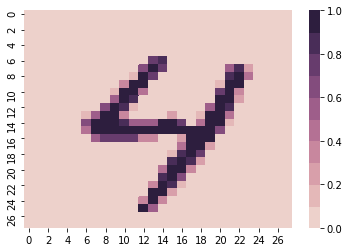

In [4]:
#datum index
i = 2019
print('This is a "{}"'.format(np.argmax(mnist.train.labels[i])))
image_example = mnist.train.images[i].reshape(28, 28)
sns.heatmap(image_example, cmap=sns.cubehelix_palette(10))
plt.show()

### Model

In [5]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

with tf.variable_scope("conv1") as scope:
    W = tf.get_variable("W", shape=[5,5,1,32], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable("b", initializer=tf.constant(0.01, shape=[32]))
    conv_1 = tf.nn.conv2d(x_image, W, strides=[1,1,1,1], padding="VALID")
    conv_1_b = tf.nn.bias_add(conv_1, b)
    conv_1_act = tf.nn.relu(conv_1_b)

pool_1 = tf.nn.max_pool(
    conv_1_act, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

with tf.variable_scope("conv2") as scope:
    W = tf.get_variable("W", shape=[5,5,32,64], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable("b", initializer=tf.constant(0.01, shape=[64]))
    conv_2 = tf.nn.conv2d(pool_1, W, strides=[1,1,1,1], padding="VALID")
    conv_2_b = tf.nn.bias_add(conv_2, b)
    conv_2_act = tf.nn.relu(conv_2_b)

pool_2 = tf.nn.max_pool(conv_2_act, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

with tf.variable_scope("fc1") as scope:
    W = tf.get_variable("W", shape=[4*4*64,1024], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable("b", initializer=tf.constant(0.01, shape=[1024]))
    flat = tf.reshape(pool_2, [-1, 4*4*64])
    fc_1 = tf.matmul(flat, W)
    fc_1_b = tf.nn.bias_add(fc_1, b)
    fc_1_act = tf.nn.relu(fc_1_b)

keep_prob = tf.placeholder(tf.float32)
fc_1_drop = tf.nn.dropout(fc_1_act, keep_prob)

with tf.variable_scope("fc2") as scope:
    W = tf.get_variable("W", shape=[1024,10], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable("b", initializer=tf.constant(0.01, shape=[10]))
    fc_2 = tf.matmul(fc_1_drop, W)
    logit_fc = tf.nn.bias_add(fc_2, b)

y_fc = tf.nn.softmax(logit_fc)

Ws = [var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if "W" in var.name]
l2_loss = tf.multiply(tf.reduce_sum([tf.nn.l2_loss(W) for W in Ws]), 0.01)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit_fc, labels=y))
train_step = tf.train.AdamOptimizer(0.0001).minimize(tf.add(cross_entropy, l2_loss))

### Session

In [6]:
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Training

In [7]:
for i in range(1000):
    batch_x, batch_y = mnist.train.next_batch(64)
    sess.run(train_step, feed_dict={ x: batch_x, y: batch_y, keep_prob: 0.5 })
    
saver.save(sess, "models/1_simple_cnn(mnist).ckpt")

'models/1_simple_cnn(mnist).ckpt'

### Result

In [8]:
#if training is excluded
#saver.restore(sess, "models/1_simple_cnn(mnist).ckpt")

correct_prediction = tf.equal(tf.argmax(y_fc, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={ x: mnist.test.images [:5000], y: mnist.test.labels[:5000], keep_prob: 1. }))

0.9512
